Estimating the bias of two coins given sample pairs $(z_1,n_1)$ and $(z_2,n_2)$ where $z_i$ is the number of heads in $n_i$ tosses for coin $i$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from functools import partial
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def bern(theta, z, N):
    # Bernoulli likelihood with N trials and z successes.
    return np.clip(theta**z * (1-theta)**(N-z), 0, 1)
def bern2(theta1, theta2, z1, z2, N1, N2):
    # Bernoulli likelihood with N trials and z successes.
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)
# def make_thetas(xmin, xmax, n):
#     xs = np.linspace(xmin, xmax, n)
#     widths =(xs[1:] - xs[:-1])/2.0
#     thetas = xs[:-1]+ widths
#     return thetas
def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection, aspect='equal'), figsize=(12,3))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.4, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.4, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.4, cmap=plt.cm.jet)
        for ax_ in ax: ax_._axis3don = False
    else:
        ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
        ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
        ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.tight_layout()
    
a, b = 2, 3
N1, z1 = 14, 11
N2, z2 = 14, 7

# thetas1 = make_thetas(0, 1, 101)
# thetas2 = make_thetas(0, 1, 101)
n = 100
width = 1/n
thetas1 = np.linspace(width/2, 1-width/2, n)
thetas2 = np.linspace(width/2, 1-width/2, n)
X, Y = np.meshgrid(thetas1, thetas2)

## Analytic solution

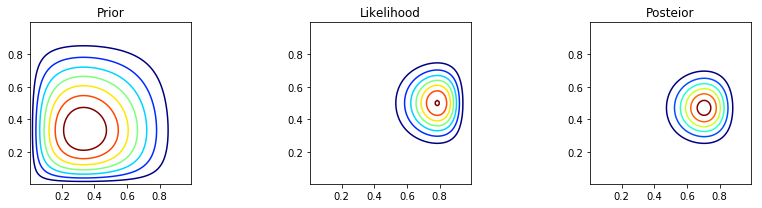

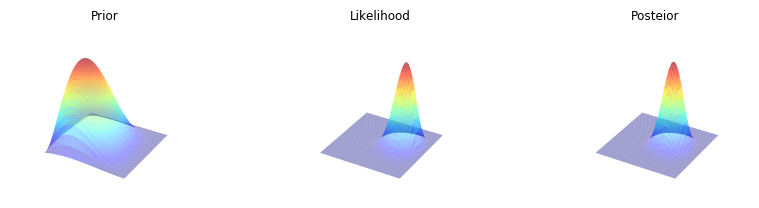

In [3]:
prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y)
likelihood = bern2(X, Y, z1, z2, N1, N2)
posterior = stats.beta(a + z1, b + N1 - z1).pdf(X) * stats.beta(a + z2, b + N2 - z2).pdf(Y)
make_plots(X, Y, prior, likelihood, posterior)
make_plots(X, Y, prior, likelihood, posterior, projection='3d')

## Grid approximation

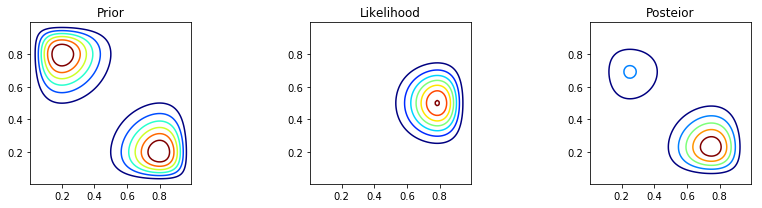

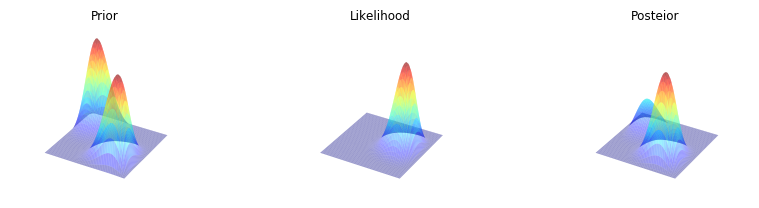

In [4]:
def c2d(width, pdf):
    area = width * width
    pmf = pdf * area
    pmf /= pmf.sum()
    return pmf

_prior = bern2(X, Y, 2, 8, 10, 10) + bern2(X, Y, 8, 2, 10, 10)
prior_grid = c2d(width, _prior)
_likelihood = bern2(X, Y, 1, 1, 2, 3)
posterior_grid = _likelihood * prior_grid
posterior_grid /= posterior_grid.sum()
make_plots(X, Y, prior_grid, likelihood, posterior_grid)
make_plots(X, Y, prior_grid, likelihood, posterior_grid, projection='3d')

## Metropolis

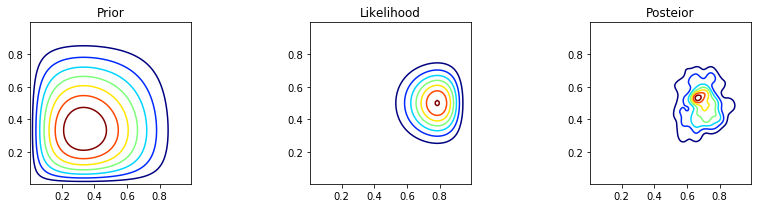

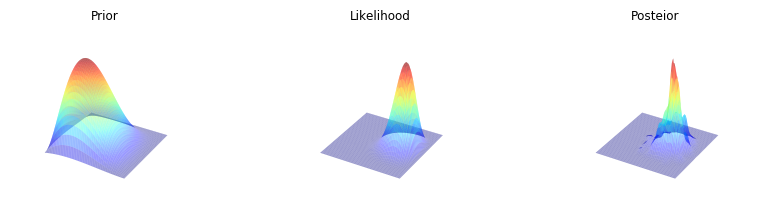

In [5]:
prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 5000
burnin = 500

thetas = np.zeros((niters-burnin, 2), np.float)
for i in range(niters):
    new_theta = stats.multivariate_normal(theta, np.diag([0.2,0.2])).rvs()
    p = min(1, target(*new_theta)/target(*theta))
    if np.random.rand() < p:
        theta = new_theta
    if i >= burnin:
        thetas[i-burnin] = theta
        
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis, projection='3d')

## Gibbs

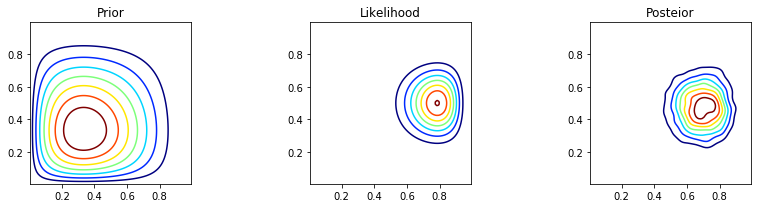

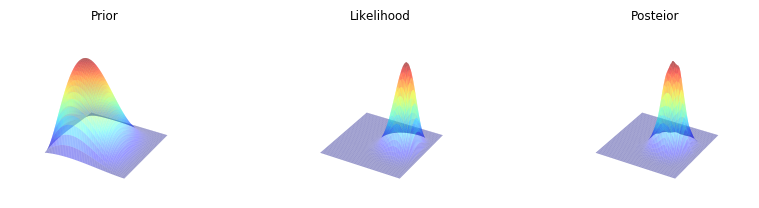

In [6]:
prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 8000
burnin = 500

thetas = np.zeros((niters-burnin,2), np.float)
for i in range(niters):
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]

    if i >= burnin:
        thetas[i-burnin] = theta
        
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs, projection='3d')